# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Like MLP_243. Tail exclusion in train and validate.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-09 17:16:00.465359


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = True
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = True
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_254' 

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-09 17:16:59.991015
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-09 17:17:00.347399
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4371
Num RCI: 4371
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4371 sequences.

Training # 1 1
2023-04-09 17:17:08.683205
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-09 17:17:08.873688
Discriminator ZERO -1
Train 1:0 720:662 52.10%
Valid 1:0 174:162 51.79%
FIT
2023-04-09 17:17:08.987001


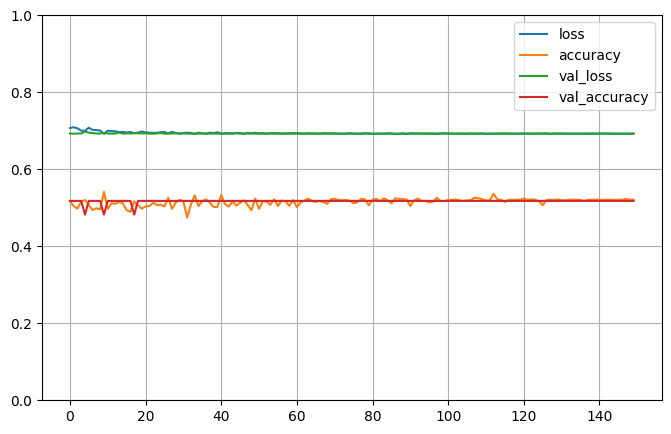


Testing # 1 1
2023-04-09 17:17:42.724386
2023-04-09 17:17:42.724438
PREDICT
2023-04-09 17:17:42.728333
Test 1:0 174:162 51.79%
Predict 1:0 336:0 100.00%
Test sizes (336, 1025) (336,)
Distrib of scores: 0.52288556 mean 1.6620068e-05 std
Range of scores: 0.52284366 to 0.52294403
Score threshold 0.5
Confusion matrix
 [[  0 162]
 [  0 174]]
Normalized matrix
 [[0.         0.48214286]
 [0.         0.51785714]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


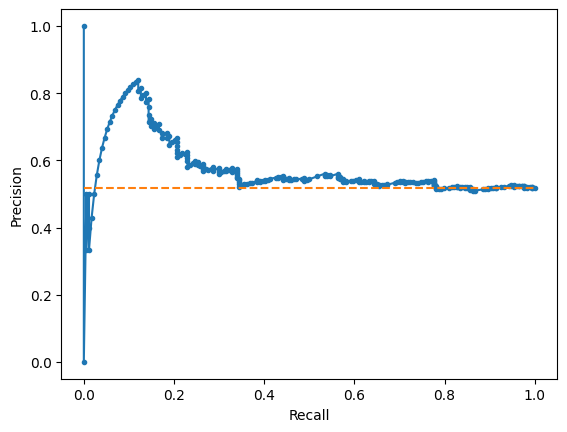

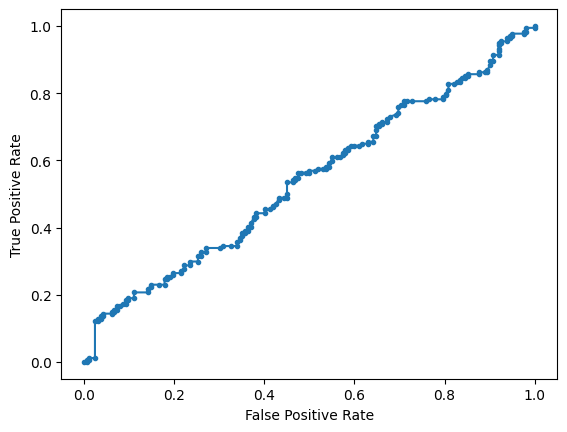

Accuracy: 51.79% Precision: 51.79% Recall: 100.00%
F1: 68.24% MCC: 0.0000
AUPRC: 57.08% AUROC: 54.10%
 accuracy [51.78571428571429]
 precision [51.78571428571429]
 recall [100.0]
 F1 [68.23529411764707]
 MCC [0.0]
 AUPRC [57.076845393469824]
 AUROC [54.09748829289058]

Training # 1 2
2023-04-09 17:17:43.328772
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-09 17:17:43.522002
Discriminator ZERO -1
Train 1:0 717:672 51.62%
Valid 1:0 177:152 53.80%
FIT
2023-04-09 17:17:43.593586


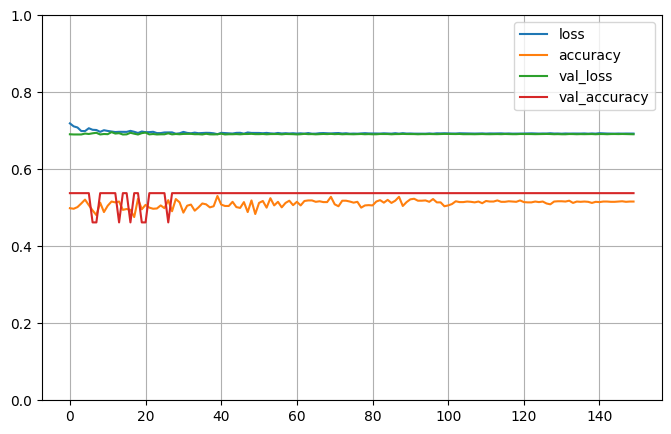


Testing # 1 2
2023-04-09 17:18:25.774000
2023-04-09 17:18:25.774043
PREDICT
2023-04-09 17:18:25.776674
Test 1:0 177:152 53.80%
Predict 1:0 329:0 100.00%
Test sizes (329, 1025) (329,)
Distrib of scores: 0.5191527 mean 2.6987815e-05 std
Range of scores: 0.51910543 to 0.5192606
Score threshold 0.5
Confusion matrix
 [[  0 152]
 [  0 177]]
Normalized matrix
 [[0.         0.46200608]
 [0.         0.53799392]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


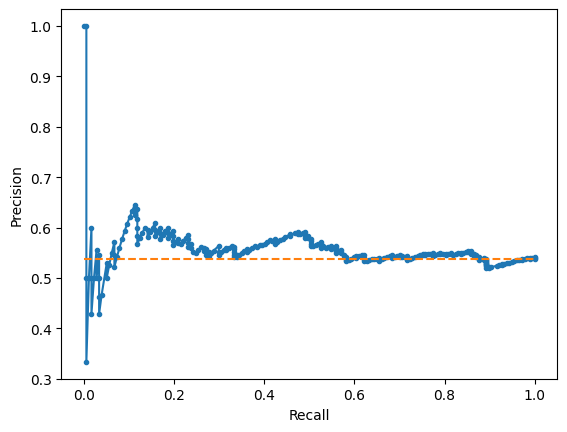

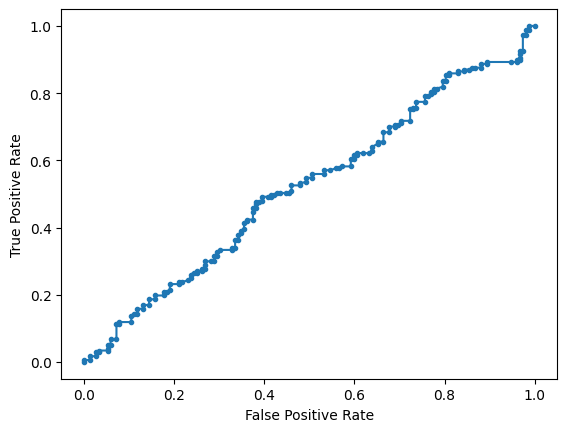

Accuracy: 53.80% Precision: 53.80% Recall: 100.00%
F1: 69.96% MCC: 0.0000
AUPRC: 55.63% AUROC: 52.04%
 accuracy [53.799392097264445]
 precision [53.799392097264445]
 recall [100.0]
 F1 [69.96047430830039]
 MCC [0.0]
 AUPRC [55.63157203475736]
 AUROC [52.044305679452876]

Training # 1 3
2023-04-09 17:18:26.552834
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-09 17:18:26.769186
Discriminator ZERO -1
Train 1:0 720:643 52.82%
Valid 1:0 174:181 49.01%
FIT
2023-04-09 17:18:26.843787


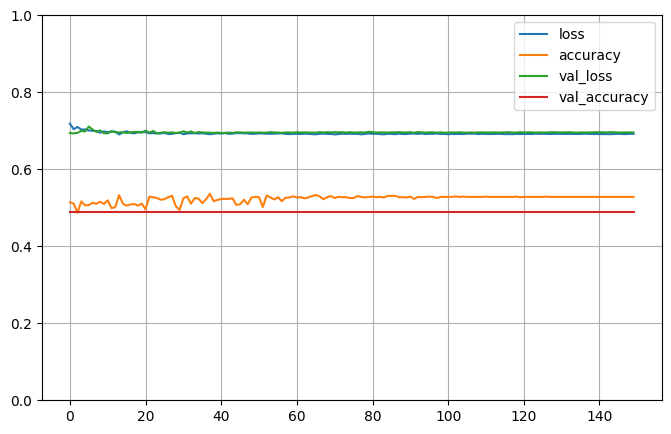


Testing # 1 3
2023-04-09 17:19:01.096004
2023-04-09 17:19:01.096440
PREDICT
2023-04-09 17:19:01.100017
Test 1:0 174:181 49.01%
Predict 1:0 355:0 100.00%
Test sizes (355, 1025) (355,)
Distrib of scores: 0.52669495 mean 1.54655e-06 std
Range of scores: 0.5266919 to 0.5267021
Score threshold 0.5
Confusion matrix
 [[  0 181]
 [  0 174]]
Normalized matrix
 [[0.         0.50985915]
 [0.         0.49014085]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


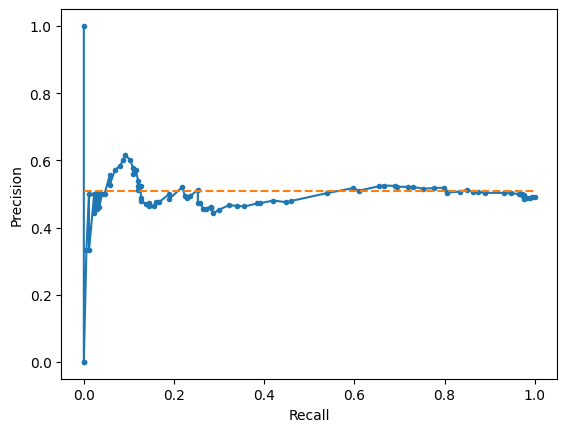

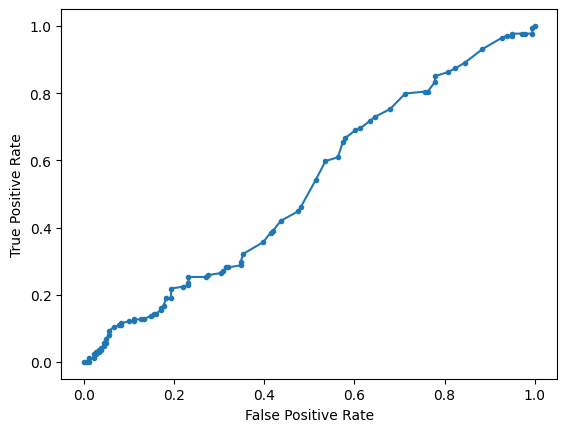

Accuracy: 49.01% Precision: 49.01% Recall: 100.00%
F1: 65.78% MCC: 0.0000
AUPRC: 49.77% AUROC: 52.16%
 accuracy [49.014084507042256]
 precision [49.014084507042256]
 recall [100.0]
 F1 [65.78449905482043]
 MCC [0.0]
 AUPRC [49.766536237836505]
 AUROC [52.16231663173938]

Training # 1 4
2023-04-09 17:19:01.940471
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-09 17:19:02.157603
Discriminator ZERO -1
Train 1:0 701:658 51.58%
Valid 1:0 193:166 53.76%
FIT
2023-04-09 17:19:02.262305


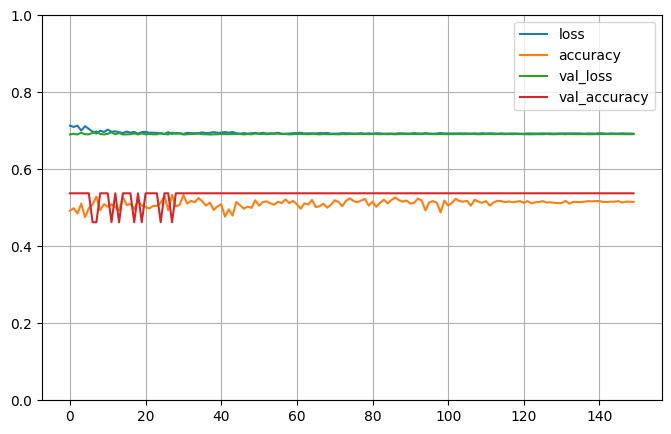


Testing # 1 4
2023-04-09 17:19:34.677001
2023-04-09 17:19:34.677047
PREDICT
2023-04-09 17:19:34.692665
Test 1:0 193:166 53.76%
Predict 1:0 359:0 100.00%
Test sizes (359, 1025) (359,)
Distrib of scores: 0.51560956 mean 1.5424963e-05 std
Range of scores: 0.5155783 to 0.5156868
Score threshold 0.5
Confusion matrix
 [[  0 166]
 [  0 193]]
Normalized matrix
 [[0.         0.46239554]
 [0.         0.53760446]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


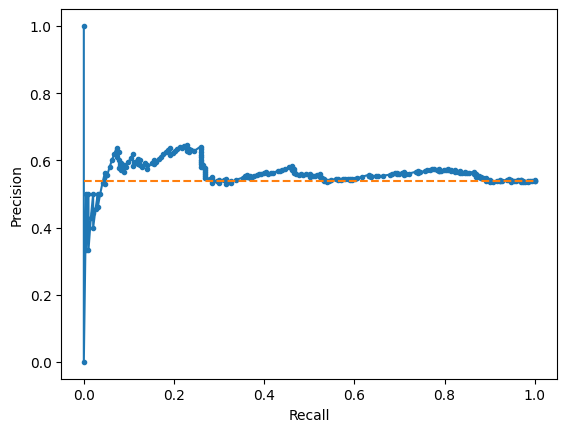

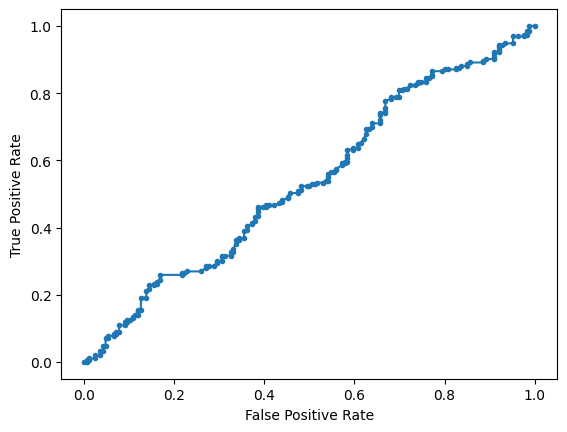

Accuracy: 53.76% Precision: 53.76% Recall: 100.00%
F1: 69.93% MCC: 0.0000
AUPRC: 56.00% AUROC: 53.72%
 accuracy [53.760445682451255]
 precision [53.760445682451255]
 recall [100.0]
 F1 [69.92753623188406]
 MCC [0.0]
 AUPRC [56.00085049706889]
 AUROC [53.72214245583369]

Training # 1 5
2023-04-09 17:19:35.208960
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-09 17:19:35.421243
Discriminator ZERO -1
Train 1:0 718:661 52.07%
Valid 1:0 176:163 51.92%
FIT
2023-04-09 17:19:35.498345


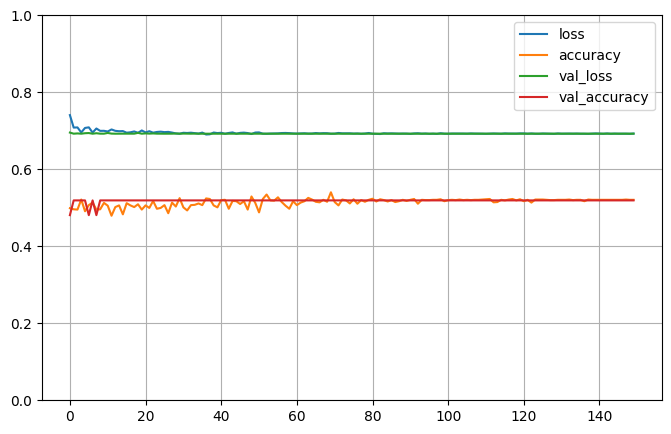


Testing # 1 5
2023-04-09 17:20:07.896529
2023-04-09 17:20:07.896580
PREDICT
2023-04-09 17:20:07.911774
Test 1:0 176:163 51.92%
Predict 1:0 339:0 100.00%
Test sizes (339, 1025) (339,)
Distrib of scores: 0.52324957 mean 4.4532794e-06 std
Range of scores: 0.5232397 to 0.52327055
Score threshold 0.5
Confusion matrix
 [[  0 163]
 [  0 176]]
Normalized matrix
 [[0.         0.48082596]
 [0.         0.51917404]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


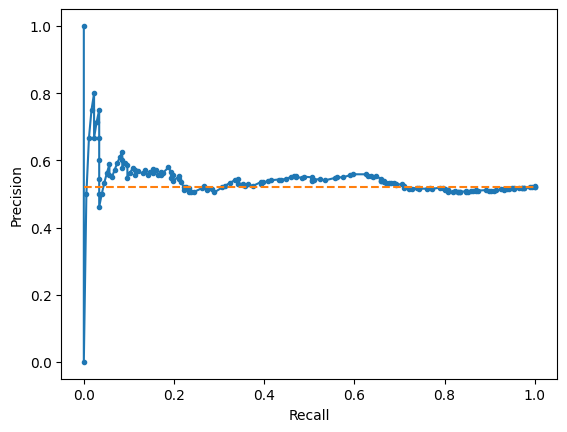

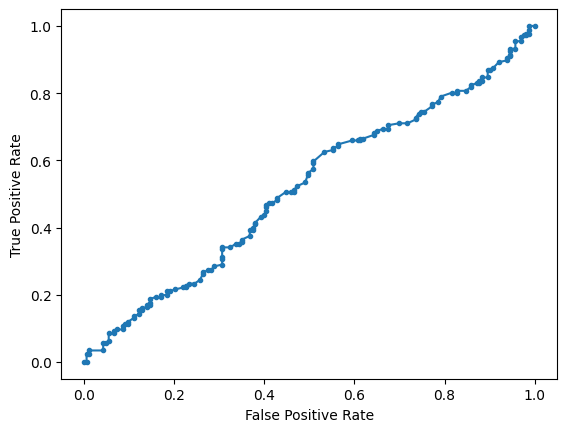

Accuracy: 51.92% Precision: 51.92% Recall: 100.00%
F1: 68.35% MCC: 0.0000
AUPRC: 53.77% AUROC: 51.62%
 accuracy [51.91740412979351]
 precision [51.91740412979351]
 recall [100.0]
 F1 [68.3495145631068]
 MCC [0.0]
 AUPRC [53.77186432844794]
 AUROC [51.624372559955376]

Training # 2 1
2023-04-09 17:20:08.497338
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-09 17:20:08.699409
Discriminator ZERO -1
Train 1:0 714:654 52.19%
Valid 1:0 180:170 51.43%
FIT
2023-04-09 17:20:08.769865


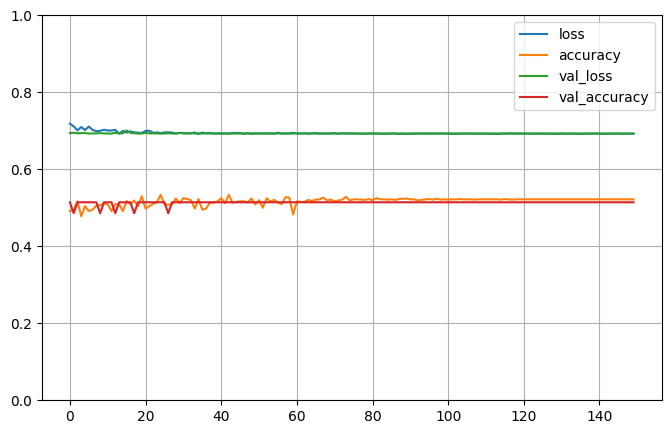


Testing # 2 1
2023-04-09 17:20:42.150423
2023-04-09 17:20:42.150791
PREDICT
2023-04-09 17:20:42.154367
Test 1:0 180:170 51.43%
Predict 1:0 350:0 100.00%
Test sizes (350, 1025) (350,)
Distrib of scores: 0.51986665 mean 2.440724e-05 std
Range of scores: 0.519819 to 0.5199765
Score threshold 0.5
Confusion matrix
 [[  0 170]
 [  0 180]]
Normalized matrix
 [[0.         0.48571429]
 [0.         0.51428571]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


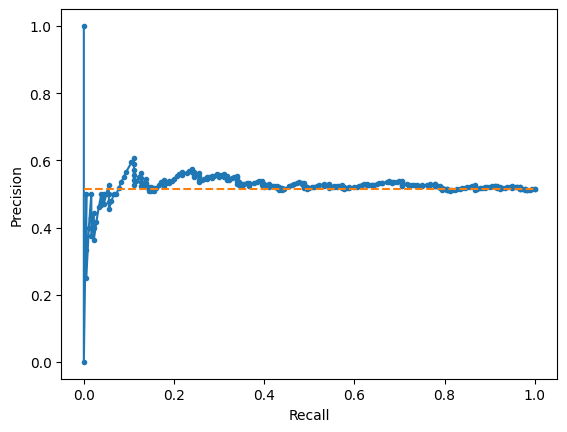

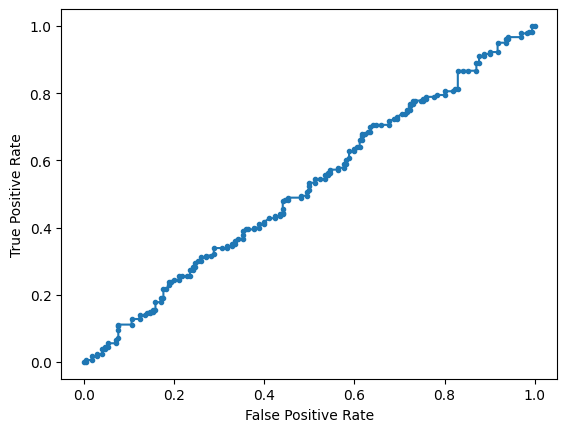

Accuracy: 51.43% Precision: 51.43% Recall: 100.00%
F1: 67.92% MCC: 0.0000
AUPRC: 52.33% AUROC: 52.05%
 accuracy [51.42857142857142]
 precision [51.42857142857142]
 recall [100.0]
 F1 [67.9245283018868]
 MCC [0.0]
 AUPRC [52.33025887454132]
 AUROC [52.053921568627445]

Training # 2 2
2023-04-09 17:20:42.687130
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-09 17:20:42.888013
Discriminator ZERO -1
Train 1:0 716:662 51.96%
Valid 1:0 178:162 52.35%
FIT
2023-04-09 17:20:42.959817


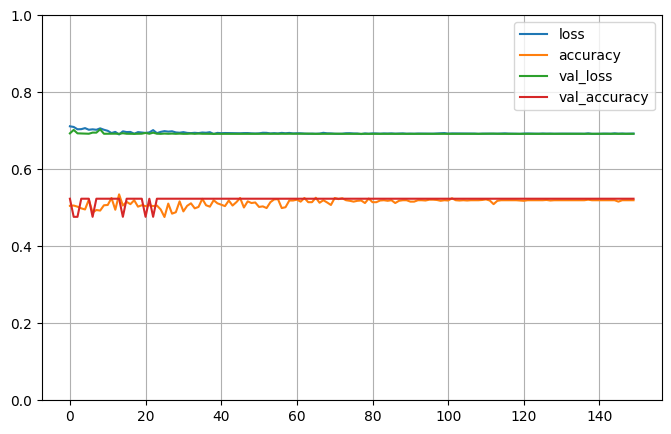


Testing # 2 2
2023-04-09 17:21:25.157669
2023-04-09 17:21:25.157712
PREDICT
2023-04-09 17:21:25.160436
Test 1:0 178:162 52.35%
Predict 1:0 340:0 100.00%
Test sizes (340, 1025) (340,)
Distrib of scores: 0.515686 mean 3.5434462e-06 std
Range of scores: 0.51567966 to 0.5157016
Score threshold 0.5
Confusion matrix
 [[  0 162]
 [  0 178]]
Normalized matrix
 [[0.         0.47647059]
 [0.         0.52352941]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


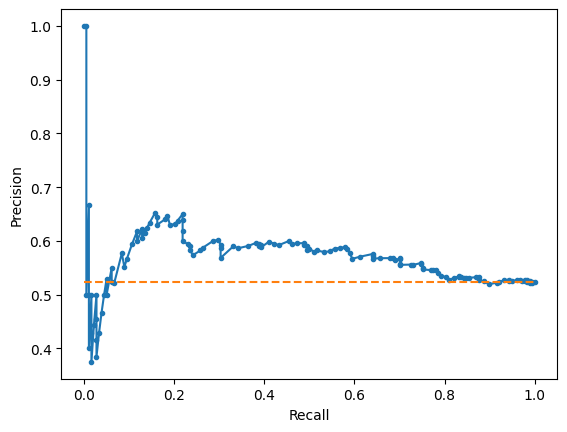

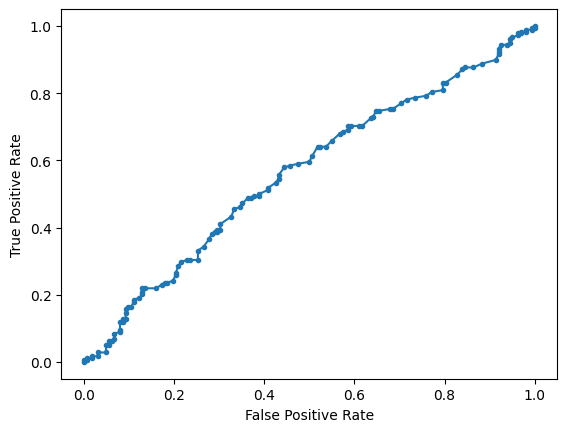

Accuracy: 52.35% Precision: 52.35% Recall: 100.00%
F1: 68.73% MCC: 0.0000
AUPRC: 57.01% AUROC: 56.37%
 accuracy [52.352941176470594]
 precision [52.352941176470594]
 recall [100.0]
 F1 [68.72586872586874]
 MCC [0.0]
 AUPRC [57.00655628004263]
 AUROC [56.370509085864896]

Training # 2 3
2023-04-09 17:21:25.724699
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-09 17:21:25.894028
Discriminator ZERO -1
Train 1:0 710:665 51.64%
Valid 1:0 184:159 53.64%
FIT
2023-04-09 17:21:25.974345


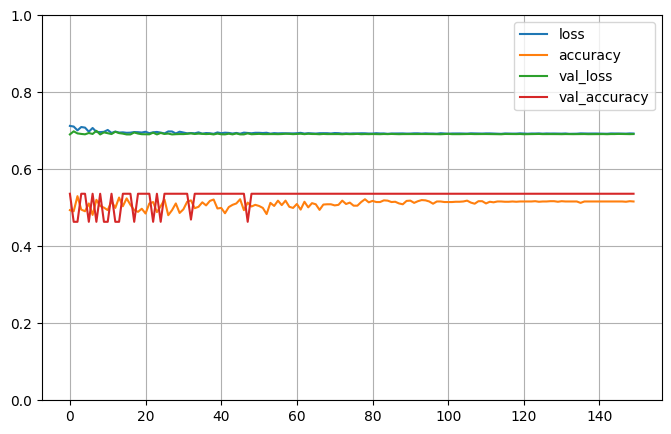


Testing # 2 3
2023-04-09 17:21:59.632201
2023-04-09 17:21:59.632245
PREDICT
2023-04-09 17:21:59.640809
Test 1:0 184:159 53.64%
Predict 1:0 343:0 100.00%
Test sizes (343, 1025) (343,)
Distrib of scores: 0.51354104 mean 2.3599492e-05 std
Range of scores: 0.51348734 to 0.51365554
Score threshold 0.5
Confusion matrix
 [[  0 159]
 [  0 184]]
Normalized matrix
 [[0.         0.46355685]
 [0.         0.53644315]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


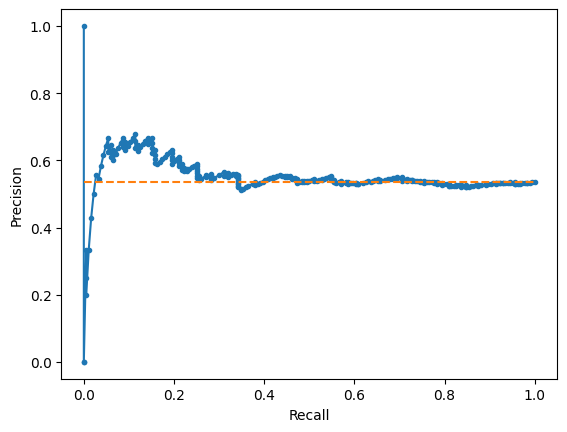

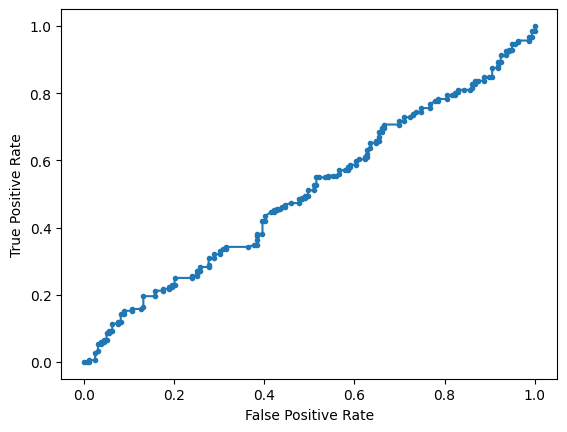

Accuracy: 53.64% Precision: 53.64% Recall: 100.00%
F1: 69.83% MCC: 0.0000
AUPRC: 55.09% AUROC: 50.65%
 accuracy [53.64431486880466]
 precision [53.64431486880466]
 recall [100.0]
 F1 [69.82922201138521]
 MCC [0.0]
 AUPRC [55.08835853791616]
 AUROC [50.64943943122778]

Training # 2 4
2023-04-09 17:22:00.173792
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-09 17:22:00.413710
Discriminator ZERO -1
Train 1:0 716:656 52.19%
Valid 1:0 178:168 51.45%
FIT
2023-04-09 17:22:00.514302


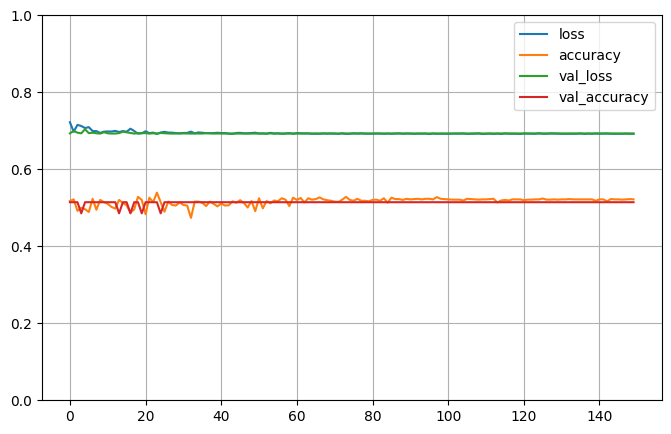


Testing # 2 4
2023-04-09 17:22:43.216665
2023-04-09 17:22:43.216723
PREDICT
2023-04-09 17:22:43.222962
Test 1:0 178:168 51.45%
Predict 1:0 346:0 100.00%
Test sizes (346, 1025) (346,)
Distrib of scores: 0.52002656 mean 3.523005e-05 std
Range of scores: 0.51994103 to 0.5201968
Score threshold 0.5
Confusion matrix
 [[  0 168]
 [  0 178]]
Normalized matrix
 [[0.         0.48554913]
 [0.         0.51445087]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


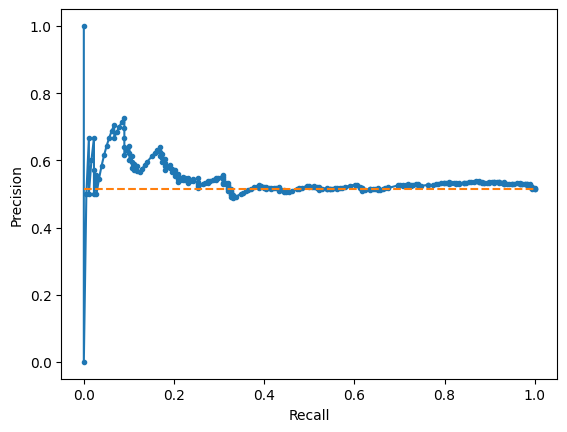

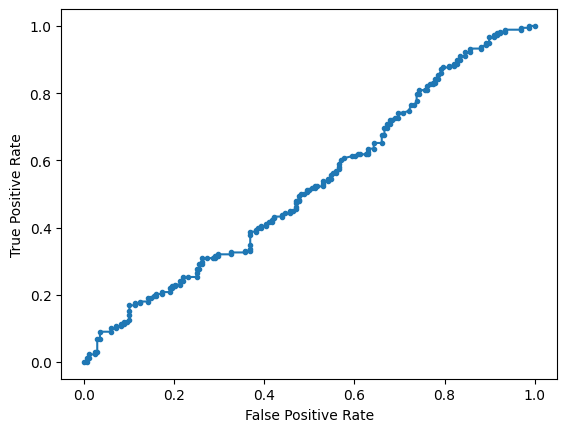

Accuracy: 51.45% Precision: 51.45% Recall: 100.00%
F1: 67.94% MCC: 0.0000
AUPRC: 54.00% AUROC: 52.64%
 accuracy [51.445086705202314]
 precision [51.445086705202314]
 recall [100.0]
 F1 [67.93893129770993]
 MCC [0.0]
 AUPRC [54.001698956747646]
 AUROC [52.6384430176565]

Training # 2 5
2023-04-09 17:22:44.067226
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-09 17:22:44.297788
Discriminator ZERO -1
Train 1:0 720:659 52.21%
Valid 1:0 174:165 51.33%
FIT
2023-04-09 17:22:44.396958


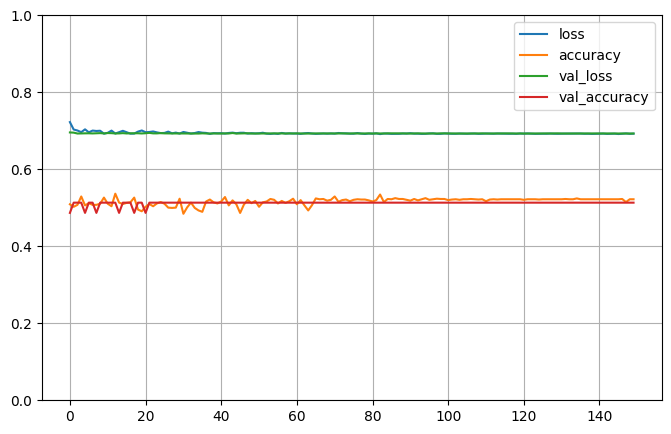


Testing # 2 5
2023-04-09 17:23:17.109927
2023-04-09 17:23:17.109970
PREDICT
2023-04-09 17:23:17.112831
Test 1:0 174:165 51.33%
Predict 1:0 339:0 100.00%
Test sizes (339, 1025) (339,)
Distrib of scores: 0.51915973 mean 1.3984403e-05 std
Range of scores: 0.5191179 to 0.5192051
Score threshold 0.5
Confusion matrix
 [[  0 165]
 [  0 174]]
Normalized matrix
 [[0.         0.48672566]
 [0.         0.51327434]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


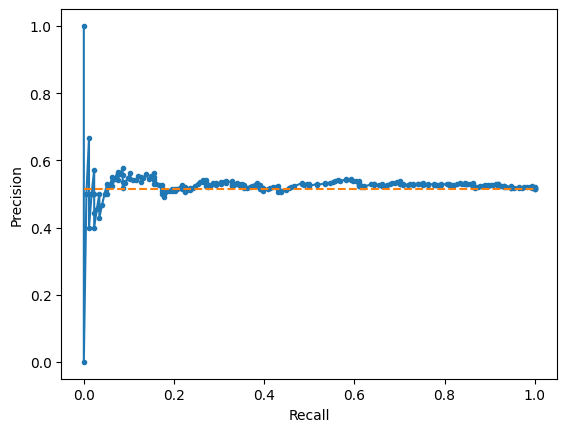

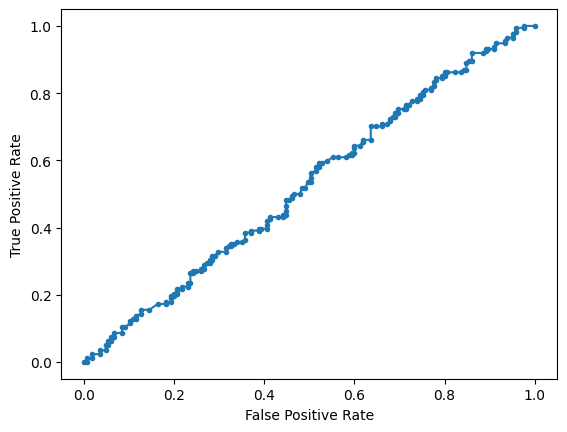

Accuracy: 51.33% Precision: 51.33% Recall: 100.00%
F1: 67.84% MCC: 0.0000
AUPRC: 52.45% AUROC: 52.57%
 accuracy [51.32743362831859]
 precision [51.32743362831859]
 recall [100.0]
 F1 [67.83625730994153]
 MCC [0.0]
 AUPRC [52.45326614725576]
 AUROC [52.57401602229189]
2023-04-09 17:23:17.650207


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 52.05% std 1.46
 precision mean 52.05% std 1.46
 recall mean 100.00% std 0.00
 F1 mean 68.45% std 1.27
 MCC mean 0.0000 std 0.0000
 AUPRC mean 54.31% std 2.32
 AUROC mean 52.79% std 1.60
 accuracy [[51.78571428571429], [53.799392097264445], [49.014084507042256], [53.760445682451255], [51.91740412979351], [51.42857142857142], [52.352941176470594], [53.64431486880466], [51.445086705202314], [51.32743362831859]]
 precision [[51.78571428571429], [53.799392097264445], [49.014084507042256], [53.760445682451255], [51.91740412979351], [51.42857142857142], [52.352941176470594], [53.64431486880466], [51.445086705202314], [51.32743362831859]]
 recall [[100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0]]
 F1 [[68.23529411764707], [69.96047430830039], [65.78449905482043], [69.92753623188406], [68.3495145631068], [67.9245283018868], [68.72586872586874], [69.82922201138521], [67.93893129770993], [67.83625730994153]]
 MCC [[0.0], [0.0], [0.0], [0.0],